# Install packages

In [11]:
#pip install lightfm

In [10]:
#pip install distributed

In [12]:
#pip install pyspark

In [13]:
#pip install dask

In [16]:
#pip install dask_jobqueue

# Package and environment setup

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import datetime
from time import time
from pyspark.sql import SparkSession

In [2]:
import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

In [3]:
import lightfm
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from itertools import islice
from collections import Counter
from scipy.sparse import csr_matrix

In [4]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://127.0.0.1:35475 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 8.00 GiB


In [5]:
# Setup and configure spark session
spark = SparkSession.builder \
  .master("local") \
  .appName("parquet_example") \
  .config('spark.sql.execution.arrow.pyspark.enabled', True) \
  .config('spark.sql.session.timeZone', 'UTC') \
  .config('spark.driver.memory','32G') \
  .config('spark.ui.showConsoleProgress', True) \
  .config('spark.sql.repl.eagerEval.enabled', True) \
  .getOrCreate()

# Enable Arrow-based columnar data
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Import dataset

In [6]:
# Read data from hdfs
df_val = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_validation.parquet')
df_test = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_test.parquet')
df_train = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_train_new.parquet')

# Data preprocessing: transform to interactions matrix

In [7]:
def preprocessing(df_train, df_test):
    
    '''
        Params:
            df: dataframe which contains 'user_id','track_id','count' columns
            
        Return: 
            interactions: 
            weights: 
    '''
    total_item_user = pd.concat([df_train, df_test])
    
    data_obj = Dataset()
    data_obj.fit(users=total_item_user['user_id'].unique(), items=total_item_user['track_id'].unique())
    
    interactions_train, weights_train = data_obj.build_interactions([(df_train['user_id'][i], df_train['track_id'][i], \
                                                                      df_train['count'][i]) for i in range(df_train.shape[0])])
    interactions_test, weights_test = data_obj.build_interactions([(df_test['user_id'][i], \
                                                          df_test['track_id'][i], df_test['count'][i]) for i in range(df_test.shape[0])])
        
    return interactions_train, weights_train, interactions_test, weights_test

# Train LightFM

In [8]:
def lightfm_train(train, rank, regParam, maxIter, model_type, weights):
    
    '''
        Params:
            train: training csr matrix in form of scipy.sparse.COOMatrix
            rank: dimensionality of the feature latent embeddings
            regParam: L2 penalty on user features
            maxIter: number of epochs to run
            model_type: 'warp' - Weighted Approximate-Rank Pairwise Loss 
                        'bpr' - Bayesian Personalised Ranking
                         these 2 model types are proved to work for implicit feedback
        Return: 
            model: lightfm model trained on training set
            
            return type: lightfm instance
    '''
    if model_type == 'bpr':
        model = LightFM(loss='bpr', no_components=rank, user_alpha=regParam)
        
    else:    
        model = LightFM(loss='warp', no_components=rank, user_alpha=regParam)

    model = model.fit(interactions=train, sample_weight=weights, epochs=maxIter, verbose=False)
    
    return model

In [9]:
def train_and_test(train, test, train_weights, rank, regParam, maxIter, top, model_type):
    
    '''
        Params:
            train: training csr matrix in form of scipy.sparse.COOMatrix
            test: test csr matrix in form of scipy_sparse_COOMatrix
            rank: dimensionality of the feature latent embeddings
            regParam: L2 penalty on user features
            maxIter: number of epochs to run
            top: number of top recommendations to evaluate on
            model_type: 'warp' - Weighted Approximate-Rank Pairwise Loss 
                        'bpr' - Bayesian Personalised Ranking
            
        Return: 
            p_at_k: precision at k
            time: time for train and evaluation
    '''
    print('Model with maxIter = {}, reg = {}, rank = {} complete'.format(maxIter,regParam,rank))
    st = time()
    
    model = lightfm_train(train, rank, regParam, maxIter, model_type, train_weights)

    t = round(time()-st, 5)
    print('Time used:', t)
    
    p_at_k = precision_at_k(model, test, k=top).mean()
    print('Precision at K:', p_at_k)
    
    return p_at_k, t

# Evaluate on validation set, maxIter = 1, regParam = 0.05, rank = 150

In [10]:
percent_train = [0.001, 0.005, 0.01, 0.05, 0.1]

In [11]:
for pct in percent_train:
    print('Model with {}% of training file size'.format(100*pct))
    sample_train = df_train.sample(False, pct).toPandas()
    sample_train = sample_train.drop('__index_level_0__', axis = 1)
    print('sample_train shape = ', sample_train.shape)
    
    if sample_train.isnull().values.any():
        print('Check null values')
    
    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
                           top=500, model_type='warp')

Model with 0.1% of training file size
sample_train shape =  (49923, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 0.66391
Precision at K: 0.004702
Model with 0.5% of training file size
sample_train shape =  (248838, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 3.08813
Precision at K: 0.0049528
Model with 1.0% of training file size
sample_train shape =  (497832, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 6.71991
Precision at K: 0.0049806
Model with 5.0% of training file size
sample_train shape =  (2492065, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 40.38718
Precision at K: 0.0050526
Model with 10.0% of training file size
sample_train shape =  (4982921, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 79.39929
Precision at K: 0.0050692


In [12]:
percent_train = [0.15]
for pct in percent_train:
    print('Model with {}% of training file size'.format(100*pct))
    sample_train = df_train.sample(False, pct).toPandas()
    sample_train = sample_train.drop('__index_level_0__', axis = 1)
    print('sample_train shape = ', sample_train.shape)
    
    if sample_train.isnull().values.any():
        print('Check null values')
    
    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
                           top=500, model_type='warp')

Model with 15.0% of training file size
sample_train shape =  (7471981, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 113.05296
Precision at K: 0.0050472


In [10]:
percent_train = [0.2]
for pct in percent_train:
    print('Model with {}% of training file size'.format(100*pct))
    sample_train = df_train.sample(False, pct).toPandas()
    sample_train = sample_train.drop('__index_level_0__', axis = 1)
    print('sample_train shape = ', sample_train.shape)
    
    if sample_train.isnull().values.any():
        print('Check null values')
    
    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
                           top=500, model_type='warp')

Model with 20.0% of training file size
sample_train shape =  (9963586, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 147.02114
Precision at K: 0.0050498


In [11]:
#percent_train = [0.3]
#for pct in percent_train:
#    print('Model with {}% of training file size'.format(100*pct))
#    sample_train = df_train.sample(False, pct).toPandas()
#    sample_train = sample_train.drop('__index_level_0__', axis = 1)
#    print('sample_train shape = ', sample_train.shape)
#    
#    if sample_train.isnull().values.any():
#        print('Check null values')
#    
#    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
#    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
#    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
#                           top=500, model_type='warp')

In [10]:
percent_train = [0.001, 0.005, 0.01, 0.05, 0.1]

In [11]:
for pct in percent_train:
    print('Model with {}% of training file size'.format(100*pct))
    sample_train = df_train.sample(False, pct).toPandas()
    sample_train = sample_train.drop('__index_level_0__', axis = 1)
    print('sample_train shape = ', sample_train.shape)
    
    if sample_train.isnull().values.any():
        print('Check null values')
    
    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
                           top=500, model_type='bpr')

Model with 0.1% of training file size
sample_train shape =  (50109, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 0.60579
Precision at K: 0.0008662001
Model with 0.5% of training file size
sample_train shape =  (248646, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 2.99508
Precision at K: 0.00022580002
Model with 1.0% of training file size
sample_train shape =  (498464, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 6.61177
Precision at K: 0.000176
Model with 5.0% of training file size
sample_train shape =  (2490905, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 41.13763
Precision at K: 0.0001648
Model with 10.0% of training file size
sample_train shape =  (4982356, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 78.97808
Precision at K: 6.1599996e-05


In [12]:
percent_train = [0.15]
for pct in percent_train:
    print('Model with {}% of training file size'.format(100*pct))
    sample_train = df_train.sample(False, pct).toPandas()
    sample_train = sample_train.drop('__index_level_0__', axis = 1)
    print('sample_train shape = ', sample_train.shape)
    
    if sample_train.isnull().values.any():
        print('Check null values')
    
    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
                           top=500, model_type='bpr')

Model with 15.0% of training file size
sample_train shape =  (7474211, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete
Time used: 112.86846
Precision at K: 5.5599998e-05


In [ ]:
#percent_train = [0.2]
#for pct in percent_train:
#    print('Model with {}% of training file size'.format(100*pct))
#    sample_train = df_train.sample(False, pct).toPandas()
#    sample_train = sample_train.drop('__index_level_0__', axis = 1)
#   print('sample_train shape = ', sample_train.shape)
#    
#   if sample_train.isnull().values.any():
#        print('Check null values')
#    
#    sample_test = df_val.toPandas().drop('__index_level_0__', axis = 1)
#    interactions_train, weights_train, interactions_test, weights_test = preprocessing(sample_train, sample_test)
#    p_at_k, t = train_and_test(interactions_train, interactions_test, weights_train, rank=150, regParam=0.05, maxIter=1,\
#                           top=500, model_type='bpr')

Model with 20.0% of training file size
sample_train shape =  (9964301, 3)
Model with maxIter = 1, reg = 0.05, rank = 150 complete


# Visualize comparison

In [1]:
import matplotlib.pyplot as plt

In [2]:
als_pct = [0.1, 0.5, 1, 5, 10, 15, 20, 30]
als_patk = [0.0029850746268656712, 0.0033964110929853167, 0.003495974235104671, 0.0037543151759695122, 0.003750449370880769, 0.0037317317317317306, 0.0037025862068965514, 0.00368924889543446]
als_time = [103.61306, 263.3297, 431.63877, 1122.6328, 1569.89445, 2043.75282, 2550.93278, 2665.39342]

In [3]:
warp_pct = [0.1, 0.5, 1, 5, 10, 15, 20]
warp_patk = [0.004702, 0.0049528, 0.0049806, 0.0050526, 0.0050692, 0.0050472, 0.0050498]
warp_time = [0.66391, 3.08813, 6.71991, 40.38718, 79.39929, 113.05296, 147.02114]

In [4]:
bpr_pct = [0.1, 0.5, 1, 5, 10, 15]
bpr_patk = [0.0008662001, 0.00022580002, 0.000176, 0.0001648, 6.1599996e-05, 5.5599998e-05]
bpr_time = [0.60579, 2.99508, 6.61177, 41.13763, 78.97808, 112.86846]

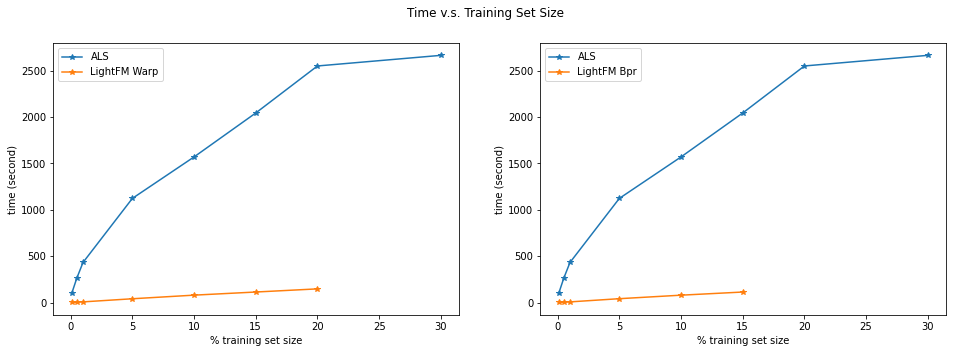

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(als_pct, als_time, '*-', label='ALS')
ax[0].plot(warp_pct, warp_time, '*-', label='LightFM Warp')
ax[1].plot(als_pct, als_time, '*-', label='ALS')
ax[1].plot(bpr_pct, bpr_time, '*-', label='LightFM Bpr')
ax[0].legend()
ax[1].legend()
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
ax[0].set_xlabel('% training set size')
ax[0].set_ylabel('time (second)')
ax[1].set_xlabel('% training set size')
ax[1].set_ylabel('time (second)')
fig.suptitle('Time v.s. Training Set Size')
plt.savefig('time.jpg', dpi=300)

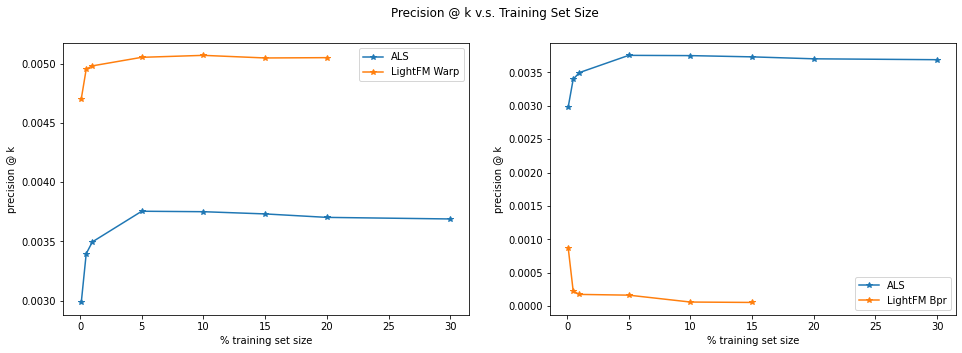

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(als_pct, als_patk, '*-', label='ALS')
ax[0].plot(warp_pct, warp_patk, '*-', label='LightFM Warp')
ax[0].legend()
ax[1].plot(als_pct, als_patk, '*-', label='ALS')
ax[1].plot(bpr_pct, bpr_patk, '*-', label='LightFM Bpr')
ax[1].legend()
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
ax[0].set_xlabel('% training set size')
ax[0].set_ylabel('precision @ k')
ax[1].set_xlabel('% training set size')
ax[1].set_ylabel('precision @ k')
fig.suptitle('Precision @ k v.s. Training Set Size')
plt.savefig('patk.jpg', dpi=300)